# Option A - Data Challenge: Build a Banking Model - Ensamble (4/4)
*Analytics for Financial Services - MBD02*
<br>
*Vilhelm Stiernstedt - 08/06/2018*


#### Section Description
In this section we will conduct all necessary data preparation such as:
1. define models
2. ensamble
3. prediction
4. submssion

## Import Libraries

In [61]:
# general libs
import collections
import time
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import hstack
import warnings

# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# lgb
import lightgbm as lgb

# sklearn libs
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# mlxtend libs (ensamle / stacking)
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import StackingClassifier

# Warning settings -> suppress depreciation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# plot settings
%matplotlib inline


# Warning settings -> suppress depreciation warnings
warnings.filterwarnings('ignore')

## Import Data

In [62]:
# import data
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

# set index - customerID
train.set_index('customerID', inplace=True)
test.set_index('customerID', inplace=True)

##  Data Preparation

In [63]:
# extract target from training set
target = train.target
# drop target from training set
train.drop('target', axis=1, inplace=True)
# One-hot encoding: Create dummies for training data
train_onehot = pd.get_dummies(train)

# Convert to numpy arrays
x = np.array(train_onehot)
y = np.array(target)

# One-hot encoding: Create dummies for training data
test_onehot = pd.get_dummies(test)
# Convert to numpy arrays
test_fin = np.array(test_onehot)


# split training data into training and validation data 80/20 split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.20, random_state=42)

In [38]:
# train dim
x.shape , y.shape

((522938, 99), (522938,))

In [39]:
test_fin.shape

(174313, 99)

### Models 

In [24]:
# model 1 - lgbm pipeline
lgbm_pipeline = Pipeline([('sel', SelectKBest(k=75)),
                          ('clf', lgb.LGBMClassifier(num_leaves=25, n_estimators=100, 
                                                     max_depth=6, learning_rate=0.075,
                                                     feature_fraction=0.8, boosting_type='dart',
                                                     bagging_freq=10, bagging_fraction=0.12)
                          )
                         ]
                        )
# model 2 - LR pipeline
lr_pipeline = Pipeline([('sel', SelectKBest(k=30)),
                        ('scaler', StandardScaler()),
                        ('clf', LogisticRegression(tol=20, solver='lbfgs'))
                       ]
                      )

# model 3 - ANN pipeline
ada_pipeline = Pipeline([('select', SelectKBest(k=10)),
                         ('clf',  AdaBoostClassifier())
                        ]
                       )

### Ensemble Models
We will try both soft and hard voting and also different weights to find the best combination. We will try to use all three models but also only use two, to see if the meta classifier finds it easier to decide best model for different classes.

In [16]:
# Define Ensemble classifers
clf1 = lgbm_pipeline # for soft: 0.33 voting right
clf2 = lr_pipeline # for soft: 0.33 voting right 
clf3 = ada_pipeline # for soft: 0.34 voting right
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[0.33,0.33,0.34])

# Define name of models and stack classifier
labels = ['LGBM', 'LR', 'ADA', 'Ensemble']

# Define classifer list
clf_list = [clf1, clf2, clf3, eclf]

In [17]:
# Assing empty lists for cross validation mean scores and std
clf_cv_mean = []
clf_cv_std = []

# Cross validate each model and plot average score 
# use of orginal x and y -> no test/validation spit as no prediction will be made
for clf, label in zip(clf_list, labels):
    scores = cross_val_score(clf, x, y, cv=3)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))
    # add mean and sd to lists
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.697 (+/- 0.001) [LGBM]
Accuracy: 0.684 (+/- 0.001) [LR]
Accuracy: 0.669 (+/- 0.001) [ADA]
Accuracy: 0.693 (+/- 0.001) [Ensemble]


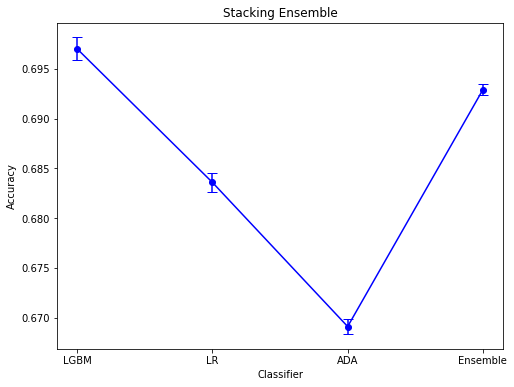

In [19]:
# Plot the accurancy of the different models
plt.figure(figsize=(8, 6))
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)

plt.xticks(range(4), ['LGBM', 'LR', 'ADA', 'Ensemble'])
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

### ROC/AUC Evaluation

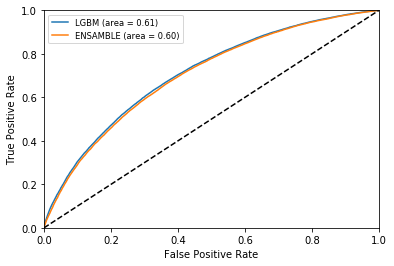

In [31]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# fit ensamble model
eclf.fit(x_train, y_train)

# define list with trained models and labels
models = [lgbm_pipeline, eclf]
labels = ['LGBM', 'ENSAMBLE']

# calc roc for each model 
for m, l in zip(models, labels):
    logit_roc_auc = roc_auc_score(y_test, m.predict_proba(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, m.predict_proba(x_test)[:,1])
    plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (l, logit_roc_auc))

# plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

### Final Model
Unfortuantely we did not mange to combine our three induvidually good models to create better model. Thus we will use the LGBM model which scores best so far.

In [40]:
# Fit model
lgbm_pipeline.fit(x, y)

Pipeline(memory=None,
     steps=[('sel', SelectKBest(k=75, score_func=<function f_classif at 0x10c5fc9d8>)), ('clf', LGBMClassifier(bagging_fraction=0.12, bagging_freq=10, boosting_type='dart',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
        learning_rate=0.075, max_depth=6, min_child_samples=2...0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1))])

In [59]:
# Make predictions for test data, input into new df
final_predictions = pd.DataFrame(lgbm_pipeline.predict_proba(test_fin))

### Submission

In [64]:
# New df
submission = pd.DataFrame()

# Import id from test_data index
submission['id'] = test.index

# import status_group predictions 
submission['prediction'] = final_predictions

# Preview
submission.head()

,id,prediction
0,D_00044539972,0.0
1,D_00074041049,1.0
2,D_00041998439,0.0
3,D_00041534199,0.0
4,D_00046605056,0.0


In [67]:
# Write submission to csv
submission.to_csv('submission_final.csv', sep=',')